In this notebook, scopes are run with different BO-based methods for the unpruned decarboxylation bromide dataset using the optimized ScopeBO settings.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.legend_handler import HandlerTuple
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
})

In order to calculate scope scores for this dataset, we first established objective bounds for the normalization of them using the workflow established in the hyperparameter optimization for the ArI oxidative addtion dataset.

NOTE: Batch size two was excluded from greedy bounds runs because it led to numerical problems of the GP surrogate model.

In [2]:
# # Low vendi and high objective bounds with the greedy acquisition function without pruning
# Benchmark().collect_data(
#     filename_labelled = "./../XEC_data/Datasets/xec_dft_data_bromide_scope.csv",
#     name_results = "./Results_Data/results_unpruned/bounds/greedy40",
#     objectives=['yield'],
#     budget = 40,
#     batches= [1,3,4],
#     Vendi_pruning_fractions = [0],
#     seeds = 40,
#     acquisition_function_mode= "greedy",
#     init_sampling_method="random")

In [3]:
# # High vendi and low objective bounds with the explorative acquisition function with max pruning for the respective batch size
# # run_settings = {1: 7, 2: 15, 3: 23, 4: 30}
# run_settings = {1: 7, 3: 23, 4: 30}
# for batch_size in run_settings.keys():
#     Benchmark().collect_data(
#             filename_labelled = "./../XEC_data/Datasets/xec_dft_data_bromide_scope.csv",
#         name_results = f"./Results_Data/results_unpruned/bounds/explorative40_b{batch_size}",
#         objectives=['yield'],
#         budget = 40,
#         batches= [batch_size],
#         Vendi_pruning_fractions = [run_settings[batch_size]],
#         seeds = 40,
#         acquisition_function_mode= "explorative",
#         pruning_metric= "vendi_batch",
#         init_sampling_method="random")

In [4]:
# Use the results of the greedy acqusition function (no pruning) with scope size 40, to get the upper bounds for the yield and the lower bounds for 
# the vendi score.
dfs_bounds_greedy = {}
for metric in ["yield","vendi"]:
    dfs_bounds_greedy[metric] = Benchmark().heatmap_plot(type_results=metric,
                                                         name_results="./Results_Data/results_unpruned"\
                                                            "/bounds/greedy40",budget=40,show_plot=False)
bounds_greedy = pd.concat(dfs_bounds_greedy,axis=1)
bounds_greedy.columns = ["yield","vendi"]
yield_max = bounds_greedy["yield"].max()
vendi_min = bounds_greedy["vendi"].min()
print(f"upper bounds yield: {yield_max}")
print(f"lower bounds vendi score: {vendi_min}")

upper bounds yield: 28.910874999999997
lower bounds vendi score: 1.9787331968893724


In [5]:
# Use the results of the explorative acqusition function (max pruning) with scope size 40, to get the lower bounds for the yield and the upper bounds for 
# the vendi score.
dfs_bounds_explorative = {}
for metric in ["yield","vendi"]:
    dfs_metric = {}
    for batch_size in [1,3,4]:
        dfs_metric[batch_size] = Benchmark().heatmap_plot(type_results=metric, budget=40, show_plot=False,
                                                          name_results=f"./Results_Data/results_unpruned"\
                                                            f"/bounds/explorative40_b{batch_size}")
    explorative_values = pd.concat(dfs_metric,axis=1)
    explorative_values.columns = [1,3,4]
    explorative_values = explorative_values.stack().reset_index(drop=True)
    dfs_bounds_explorative[metric] = pd.DataFrame({metric: explorative_values})
bounds_explorative = pd.concat(dfs_bounds_explorative,axis=1)
bounds_explorative.columns = ["yield","vendi"]
yield_min = bounds_explorative["yield"].min()
vendi_max = bounds_explorative["vendi"].max()
print(f"lower bounds yield: {yield_min}")
print(f"upper bounds vendi score: {vendi_max}")

lower bounds yield: 8.153875
upper bounds vendi score: 5.254335536012542


In [6]:
# Record the bounds
yield_bounds = (yield_max,yield_min)
vendi_bounds = (vendi_max,vendi_min)
bounds = {"yield": yield_bounds, "vendi": vendi_bounds}

After having established the bounds for the objectives, we can run the scopes with different acquisition functions using the optimized conditions and also without Vendi pruning.

In [7]:
# for acq in ["ei","random-selection","greedy","explorative"]:
#     if acq == "ei":
#         acq_label = "balanced"
#     elif acq == "random-selection":
#         acq_label = "random"
#     else:
#         acq_label = acq
#     for pruning in [False,True]:
#         if pruning:
#             pruning_label = "with-pruning"
#             pruning_fraction = 13
#         else:
#             pruning_label = "no-pruning"
#             pruning_fraction = 0
#         Benchmark().collect_data(
#             filename_labelled = f"./../XEC_data/Datasets/xec_dft_data_bromide_scope.csv",
#             name_results = f"./Results_Data/results_unpruned/scope_{acq}_{pruning_label}",
#             objectives=['yield'],
#             budget = 27,
#             batches= [3],
#             Vendi_pruning_fractions = [pruning_fraction],
#             seeds = 40,
#             acquisition_function_mode= acq_label,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random")

In [8]:
# # simulate scopes similar to how humans conventionally select scopes
# Benchmark().collect_data(
#     filename_labelled = f"./../XEC_data/Datasets/xec_dft_data_bromide_scope.csv",
#     name_results = f"./Results_Data/results_unpruned/scope_human-like-acq",
#     objectives=['yield'],
#     budget = 27,
#     batches= [3],
#     Vendi_pruning_fractions = [5],
#     seeds = 40,
#     acquisition_function_mode= "greedy",
#     pruning_metric= "vendi_batch",
#     init_sampling_method="random")

Visualize the results

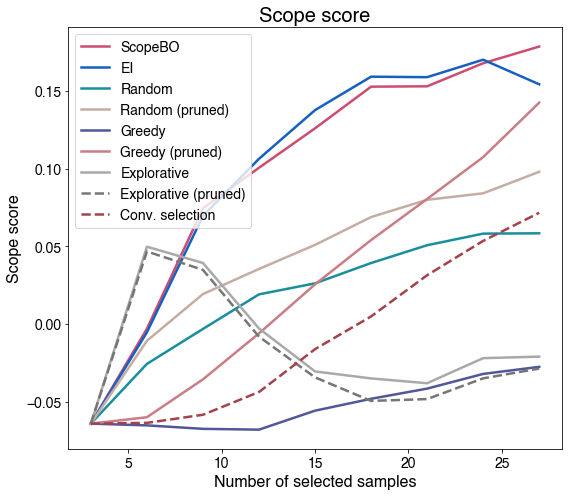

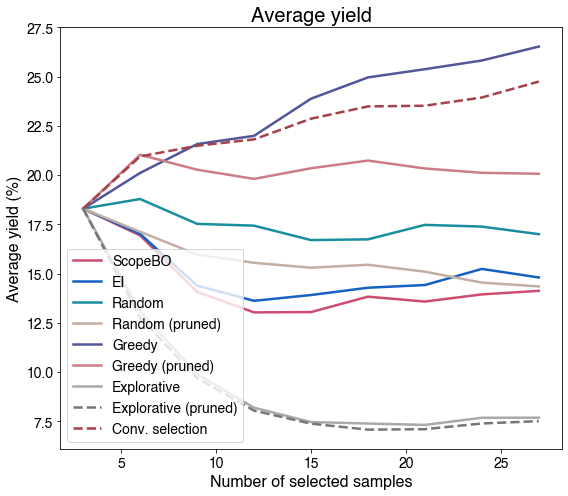

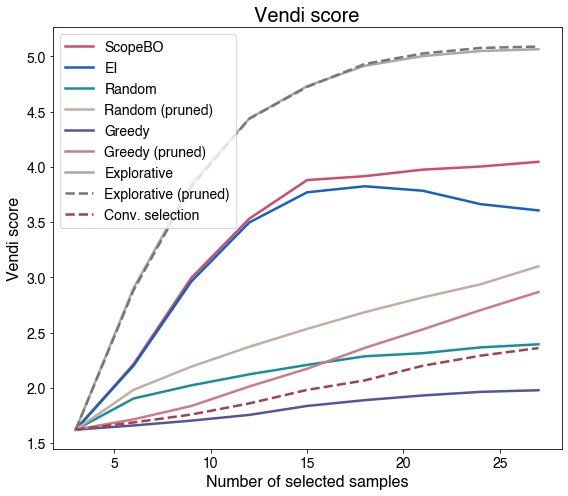

In [9]:
def score_overview(metrics):
    for type_results in metrics:
        # Initialize the figure
        plt.figure(figsize=(8,7))
        dfs = {}
        for acq in ["EI","Random","Greedy","Explorative","Conv. selection"]:
            if acq.lower() == "random":
                acq_label = "random-selection"
            elif acq == "Conv. selection":
                acq_label = "human-like-acq"
            else:
                acq_label = acq.lower()
            for pruning in [False,True]:
                if pruning:
                    pruning_label = "_with-pruning"
                else:
                    pruning_label = "_no-pruning"
                if acq == "Conv. selection":
                    pruning_label = ""
                dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                        name_results=f"./Results_Data/results_unpruned/scope_{acq_label}{pruning_label}",
                                        bounds=bounds,show_plot=False)
                dfs[acq+pruning_label] = dfs_progress["means"]
        df_combined = pd.concat(dfs,axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        df_combined.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
        df_combined = df_combined[["ScopeBO"] + [col for col in df_combined.columns if col != "ScopeBO"]]
        label_dict = {col: col for col in df_combined.columns}
        for key,val in label_dict.items():
            if "_no-pruning" in val:
                label_dict[key] = val.split("_")[0]
            elif "with-pruning" in val:
                label_dict[key] = val.split("_")[0] + " (pruned)"
            df_combined.rename(columns=label_dict,inplace=True)
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
        plt.xlabel('Number of selected samples',fontsize=16)
        plt.ylabel(f"{type_results} score",fontsize=16)
        if type_results == "Objective":
            plt.title("Average yield",fontsize=20)
            plt.ylabel(f"Average yield (%)",fontsize=16)

        else:
            plt.title(f"{type_results} score",fontsize=20)
            plt.ylabel(f"{type_results} score",fontsize=16)

        plt.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

score_overview(["Scope"])
score_overview(["Objective","Vendi"])

Summary plot for all metrics

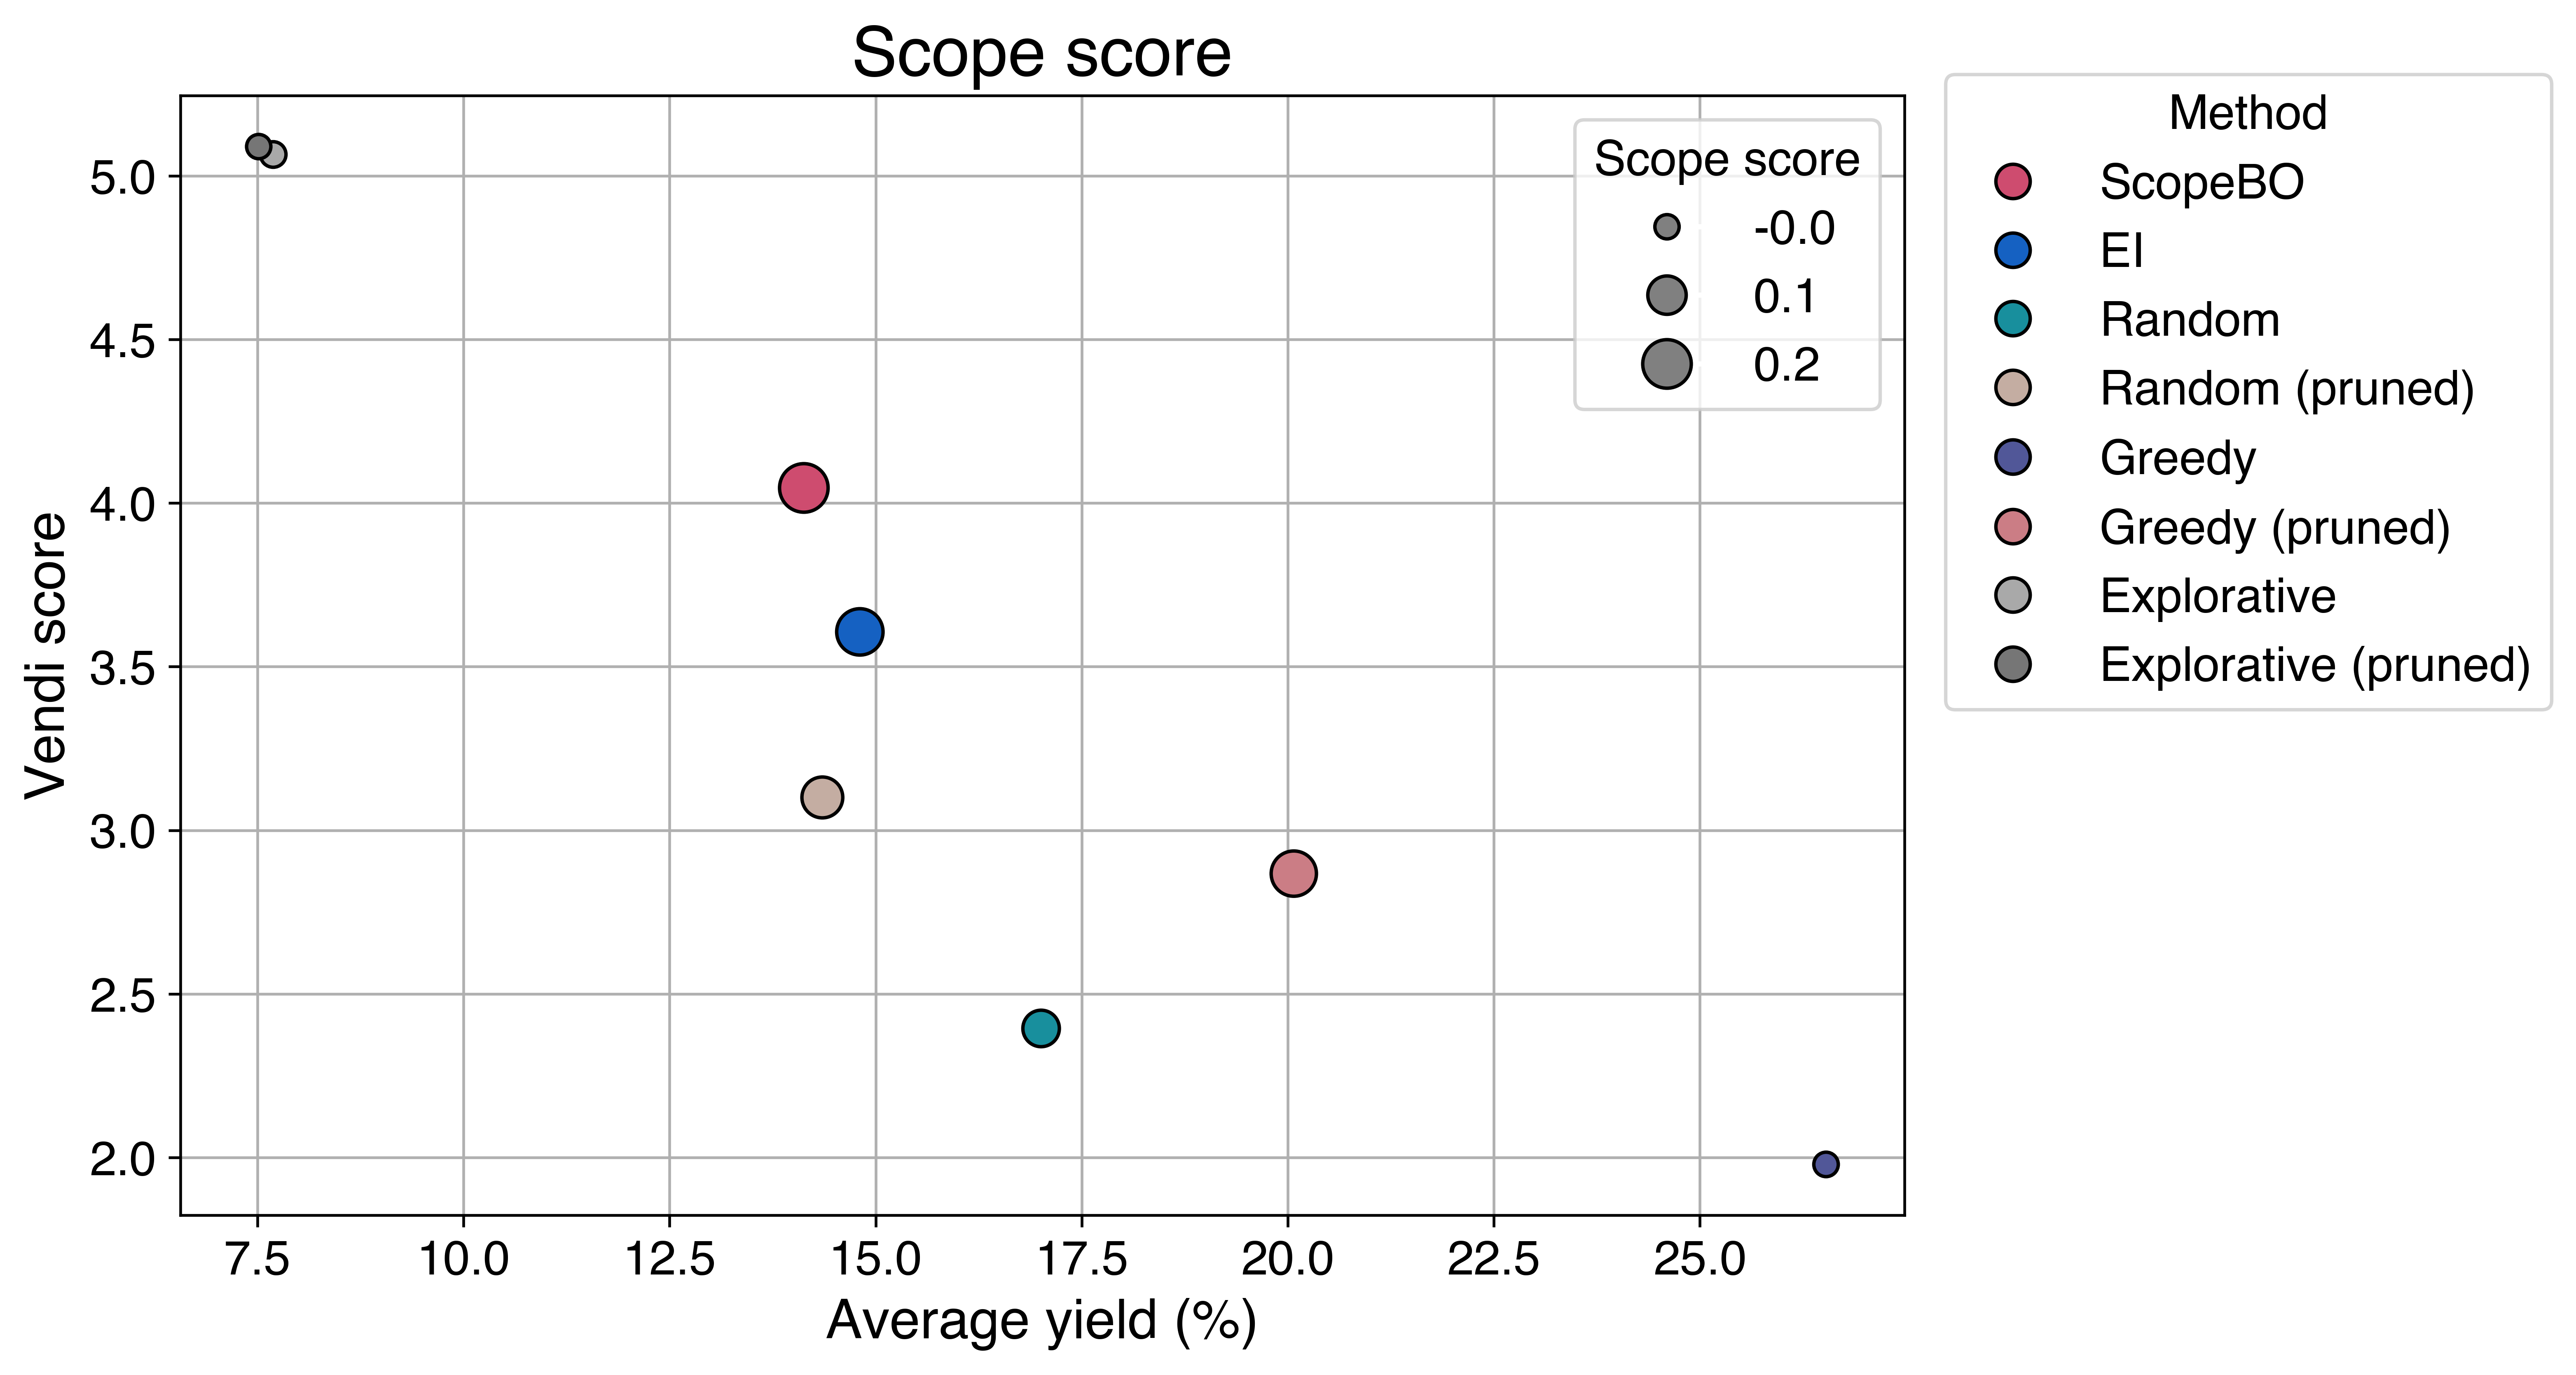

,ScopeBO,EI,Random,Random (pruned),Greedy,Greedy (pruned),Explorative,Explorative (pruned)
Average yield (%),14.127963,14.807778,17.006944,14.352778,26.530278,20.072685,7.690093,7.514444
Vendi score,4.046228,3.606267,2.394156,3.100245,1.978586,2.867431,5.065406,5.089516
Scope score,0.178489,0.154233,0.058422,0.097962,-0.027440,0.142418,-0.020870,-0.028548


In [10]:
acq_fct = ["EI","Random","Greedy","Explorative"]
pruning_opt = [False,True]
datasets = ["high","medium","low"]

map_data = {}
for acq in acq_fct:
    acq_label = acq.lower()
    if acq == "Random":
        acq_label = "random-selection"
    for pruning in [False,True]:
        if pruning:
            pruning_label = "with-pruning"
        else:
            pruning_label = "no-pruning"
        run_results = []
        for type_results in ["Objective","Vendi","Scope"]:
            dfs_scaled, _ = Benchmark.get_metric_overview(budget=27,type_results=type_results,
                                            name_results=f"./Results_Data/results_unpruned/scope_{acq_label}_{pruning_label}",
                                            bounds = bounds, directory=".")
            run_results.append(dfs_scaled["means"].iloc[-1,0])  # save the last mean which is the result at the end of the scope
        map_data[f"{acq}_{pruning_label}"] = run_results
map_df = pd.DataFrame.from_dict(map_data)
map_df.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
map_df = map_df[["ScopeBO"] + [col for col in map_df.columns if col != "ScopeBO"]]
label_dict = {col: col for col in map_df.columns}
for key,val in label_dict.items():
    if "_no-pruning" in val:
        label_dict[key] = val.split("_")[0]
    elif "with-pruning" in val:
        label_dict[key] = val.split("_")[0] + " (pruned)"
map_df.rename(columns=label_dict,inplace=True)

# Plot the results
x = map_df.iloc[0]
y = map_df.iloc[1]
raw_size_data = map_df.iloc[2]
labels = map_df.columns

size_min, size_max = 50, 200
data_min, data_max= raw_size_data.min(), raw_size_data.max()
sizes = size_min + (raw_size_data - data_min) * (size_max - size_min) / (data_max - data_min)

# simplify the labels for the legend
labels = list(labels)
for i,val in enumerate(labels):
    if val == "EI_pruning":
        labels[i] = "ScopeBO"
    elif "no-pruning" in val:
        labels[i] = val.split("_")[0]
    elif "_pruning" in val:
        labels[i] = val.split("_")[0] + " (pruned)"

color_map = {label: all_colors[i] for i, label in enumerate(labels)}
colors = [color_map[label] for label in labels]
alpha_val = 1

plt.figure(figsize=(9,6),dpi=600)
plt.title(f"Performance map")
plt.scatter(x, y, s=sizes, alpha=alpha_val, c = colors, edgecolors="k", zorder = 2)

plt.xlabel('Average yield (%)')
plt.ylabel('Vendi score')
plt.title('Scope score')
plt.grid(True, zorder =1)

# legend for the method (color)
color_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=label,
        markerfacecolor=color_map[label],
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=10
    )
    for label in labels
]

# legend for the scope score (size)
# Choose representative raw size values
size_legend_values = np.linspace(raw_size_data.min(), raw_size_data.max(), 3)
size_legend_sizes = size_min + (size_legend_values - data_min) * (size_max - size_min) / (data_max - data_min)
size_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{val:.1f}',
        markerfacecolor='gray',
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=np.sqrt(s)  # matplotlib sizes are in area, markersize is radius
    )
    for val, s in zip(size_legend_values, size_legend_sizes)
]

# Add legends
first_legend = plt.legend(handles=color_legend, loc = "lower left", title="Method", frameon=True,
                          bbox_to_anchor=(1.01, 0.43))
plt.gca().add_artist(first_legend)

second_legend = plt.legend(handles=size_legend, title="Scope score", frameon=True)

plt.show()

map_df.index = ["Average yield (%)","Vendi score", "Scope score"]
map_df